In [2]:
import os
import numpy as np
import pandas as pd
import sys
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import peakutils
sns.set()

In [2]:
#função para dar dataframe de coverage
def getDataCSVs(data_name, filepath):
    listcsv = glob.glob(data_name)
    mt = re.compile(r'(.*)\.(.*)\.(.*)')
    flist = ()
    for inst in listcsv:
        flist += ([inst,int(mt.sub(r'\2',inst))],)
    listcsv = sorted(flist, key = lambda x: x[1])
    slist = [el[0] for el in listcsv]
    data = pd.read_csv(slist[0])
    for i, el in enumerate(slist[1:]):
        data = pd.concat([data,pd.read_csv(el)])
        

    folders = []
    for i in range(0,10):
        folders += glob.glob(str(i)+'*')
        
    folders2 = []
    for i in range(0,10):
        folders2 += glob.glob('*.csv')
    folders2.append('0.orgg')
    
    folders3 = set(folders) - set(folders2)
    
    time = sorted([float(l) for l in folders3])
    #print(time)
    data['time'] = time[0:len(data)]
    data.fillna(value = 0, inplace = True) #deals with NaN values by filling them with zeros since they are too low
    return data

In [6]:
modelcentered_model_list = ['centered','2c','3c','4c','5c','7c','8c','9c','10c'] #all model numbers for the centered patterns
modeldiagonal_model_list = ['diagonal','1d','2d','3d','4d','5d','7d','8d','9d','10d'] #all model numbers for the diagonal patterns
modeldiagonal2_model_list = ['diagonal','1d2','2d2','3d2','4d2','5d2','7d2','8d2','9d2','10d2'] #all model numbers for the diagonal patterns

In [10]:
#stores all data from models specified in list parameters
def getAllData(modeltypelist, modellist, lstmod, thresholdslist):
    for tmodel in modeltypelist:
        for nmodel in modellist[1:]:    

            folder = "/home/caio/models/model"+modellist[0]
            if (nmodel[-1] != '2'):
                filepath = '/model' + nmodel[:-1] + '/model' + nmodel[:-1] +"_"+tmodel+"/"
            else:
                filepath = '/model' + nmodel[:-2] + '/model' + nmodel[:-2] +"_"+tmodel+"/"
            os.chdir(folder + filepath)

            #Create all data frames from .csv files
            for threshold in thresholdslist:
                lstmod['df_' + nmodel + '_' + tmodel + '_' + str(threshold)] = getDataCSVs(nmodel+'volthr'+str(threshold)+'.*.csv', filepath)    

In [43]:
lst = {}                      # data frame for all models with all thresholds
thresholds = list(range(1,5)) # thresholds in mol/L                 #type of model

getAllData('1',modeldiagonal_model_list, lst, thresholds) #gets all data from diagonal models type 1
getAllData('1',modelcentered_model_list, lst, thresholds) #gets all data from centered models type 1
getAllData('2',modeldiagonal2_model_list, lst, thresholds) #gets all data from diagonal models type 2

In [12]:
#Defines preprocessing function to be used in the next cell
def preprocessing(dtframe, alllabels, threshold):
    #Dropping unnecessary columns from DF
    dtframe.drop(labels = alllabels, axis = 1, inplace = True)
    #Renames Con and Vol columns
    dtframe.rename(columns={
                    'Con': 'Con_' + threshold,
                    'Volume': 'Volume_' + threshold
                }, inplace = True)

In [42]:
def buildFinalDataFrame(modeltype, modellist, dfs_dict):
    #Preprocessing DFs
    for nmodel in modellist[1:]: 
        #Average magnitude of velocity U per time for the model
        if not set(['U']).issubset(lst['df_' + nmodel + '_'+ modeltype +'_1'].columns):
            lst['df_' + nmodel + '_'+ modeltype +'_1']['U'] = np.sqrt(
                np.power(np.array(lst['df_' + nmodel + '_'+ modeltype +'_1']['U:0']),2) + 
                np.power(np.array(lst['df_' + nmodel + '_'+ modeltype +'_1']['U:1']),2) + 
                np.power(np.array(lst['df_' + nmodel + '_'+ modeltype +'_1']['U:2']),2)) 
            #Finishes preprocessing
            preprocessing(lst['df_' + nmodel + '_'+ modeltype +'_1'], ['U:0','U:1','U:2','Cell Type'], '1')
            # creates model final DF
            dfs_dict['df_' + nmodel + '_'+ modeltype] = lst['df_' + nmodel + '_'+ modeltype +'_1'].copy() 

            #Drops redundant columns, renames remaining columns and merges
            #dfs into a single df under the corresponding model key
            for key, df in list(lst.items()):
                if (key[4] == 'c' or key[4] == 'd'):
                    if key[5] != '2':
                        if (key[-1] != '1' and key[3:5] == nmodel):
                            #Preprocesses and merges df with the final model DF
                            preprocessing(df, ['U:0','U:1','U:2','p','Cell Type'], key[-1])
                            dfs_dict['df_' + nmodel + '_'+ modeltype] = dfs_dict['df_' + nmodel + '_'+ modeltype].merge(df, how='inner', on='time')
                    else:
                        if (key[-1] != '1' and key[3:6] == nmodel):
                            #Preprocesses and merges df with the final model DF
                            preprocessing(df, ['U:0','U:1','U:2','p','Cell Type'], key[-1])
                            dfs_dict['df_' + nmodel + '_'+ modeltype] = dfs_dict['df_' + nmodel + '_'+ modeltype].merge(df, how='inner', on='time')
                else: # unfortunately, model 10 is a special case, it has 2 digits and we need this extra code chunk
                    if key[6] != '2':
                        if (key[-1] != '1' and key[3:6] == nmodel):
                            #Preprocesses and merges df with the final model DF
                            preprocessing(df, ['U:0','U:1','U:2','p','Cell Type'], key[-1])
                            dfs_dict['df_' + nmodel + '_'+ modeltype] = dfs_dict['df_' + nmodel + '_'+ modeltype].merge(df, how='inner', on='time')
                    else:
                        if (key[-1] != '1' and key[3:7] == nmodel):
                            #Preprocesses and merges df with the final model DF
                            preprocessing(df, ['U:0','U:1','U:2','p','Cell Type'], key[-1])
                            dfs_dict['df_' + nmodel + '_'+ modeltype] = dfs_dict['df_' + nmodel + '_'+ modeltype].merge(df, how='inner', on='time')

In [40]:
#Assigning the total volume value to a variable
voltot = 7.5/1000000

In [44]:
dfs_cent = {} #final preprocessed DFs, each key refers to one model
dfs_diag = {}
dfs_diag2 = {}
buildFinalDataFrame('1', modeldiagonal_model_list, dfs_diag)
buildFinalDataFrame('2', modeldiagonal2_model_list, dfs_diag2)
buildFinalDataFrame('1', modelcentered_model_list, dfs_cent)

In [46]:
#creates time index in hours
for df in dfs_cent.values():
    df['time_hours'] = df['time']/3600
    df.drop(labels='time', axis = 1, inplace = True)
    
for df in dfs_diag.values():
    df['time_hours'] = df['time']/3600
    df.drop(labels='time', axis = 1, inplace = True)
    
for df in dfs_diag2.values():
    df['time_hours'] = df['time']/3600
    df.drop(labels='time', axis = 1, inplace = True)
#   df.set_index('time_seconds', inplace = True)

In [47]:
#dfplot = dfs_final['df_2c_1']
dfplot = pd.DataFrame()
for df in list(dfs_cent.values()):
    dfplot = pd.concat([dfplot, df], ignore_index=True)
    
dfplotdiag = pd.DataFrame()
for df in list(dfs_diag.values()):
    dfplotdiag = pd.concat([dfplotdiag, df], ignore_index=True)
    
dfplotdiag2 = pd.DataFrame()
for df in list(dfs_diag2.values()):
    dfplotdiag2 = pd.concat([dfplotdiag2, df], ignore_index=True)

In [45]:
dfs_diag['df_8d_1']

,Con_1,Volume_1,p,time,U,Con_4,Volume_4,Con_2,Volume_2,Con_3,Volume_3
0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00,0.5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,1.264350e-10,6.931900e-11,1.385960e-14,1.0,7.739439e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,5.284500e-10,2.224670e-10,4.448340e-14,1.5,2.075710e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,8.554780e-10,3.101350e-10,6.201140e-14,2.0,2.635143e-14,0.000000e+00,0.000000e+00,3.297300e-10,1.007080e-10,0.000000e+00,0.000000e+00
5,1.333280e-09,4.714310e-10,9.424900e-14,2.5,3.995573e-14,0.000000e+00,0.000000e+00,5.995530e-10,1.674460e-10,6.652280e-12,1.699170e-12
6,1.744860e-09,5.835300e-10,1.166570e-13,3.0,4.799846e-14,0.000000e+00,0.000000e+00,8.348710e-10,2.205710e-10,2.784380e-10,6.762150e-11
7,2.179640e-09,7.137350e-10,1.426770e-13,3.5,5.844036e-14,0.000000e+00,0.000000e+00,1.116090e-09,2.906220e-10,5.209610e-10,1.219160e-10
8,2.623250e-09,8.467550e-10,1.692520e-13,4.0,6.966513e-14,7.826880e-12,1.699170e-12,1.551890e-09,4.006010e-10,6.750360e-10,1.535440e-10
9,3.050360e-09,9.558860e-10,1.910610e-13,4.5,7.649762e-14,1.493790e-10,3.191240e-11,1.864860e-09,4.715780e-10,8.465200e-10,1.893930e-10


In [48]:
for thrsh in range(1,5):
    dfplot['Vol_'+str(thrsh)] = dfplot['Volume_'+str(thrsh)]/voltot
    dfplot.drop(labels='Volume_'+str(thrsh), axis=1, inplace = True)
    
for thrsh in range(1,5):
    dfplotdiag['Vol_'+str(thrsh)] = dfplotdiag['Volume_'+str(thrsh)]/voltot
    dfplotdiag.drop(labels='Volume_'+str(thrsh), axis=1, inplace = True)
    
for thrsh in range(1,5):
    dfplotdiag2['Vol_'+str(thrsh)] = dfplotdiag2['Volume_'+str(thrsh)]/voltot
    dfplotdiag2.drop(labels='Volume_'+str(thrsh), axis=1, inplace = True)

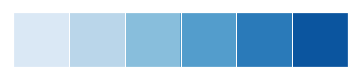

In [194]:
sns.palplot(sns.color_palette("Blues"))

In [49]:
columns = ['Con_' + str(i) for i in range(1,5)] + ['U','p']
for thrsh in range(1,5):
    dfplot.drop(labels=columns, axis=1, inplace = True)
    dfplotdiag.drop(labels=columns, axis=1, inplace = True)
    dfplotdiag2.drop(labels=columns, axis=1, inplace = True)

ValueError: labels ['Con_1' 'Con_2' 'Con_3' 'Con_4' 'U' 'p'] not contained in axis

In [ ]:
dfplotdiag2

In [53]:
dfplot.set_index('time_hours', inplace=True)
dfplotdiag.set_index('time_hours', inplace=True)
dfplotdiag2.set_index('time_hours', inplace=True)

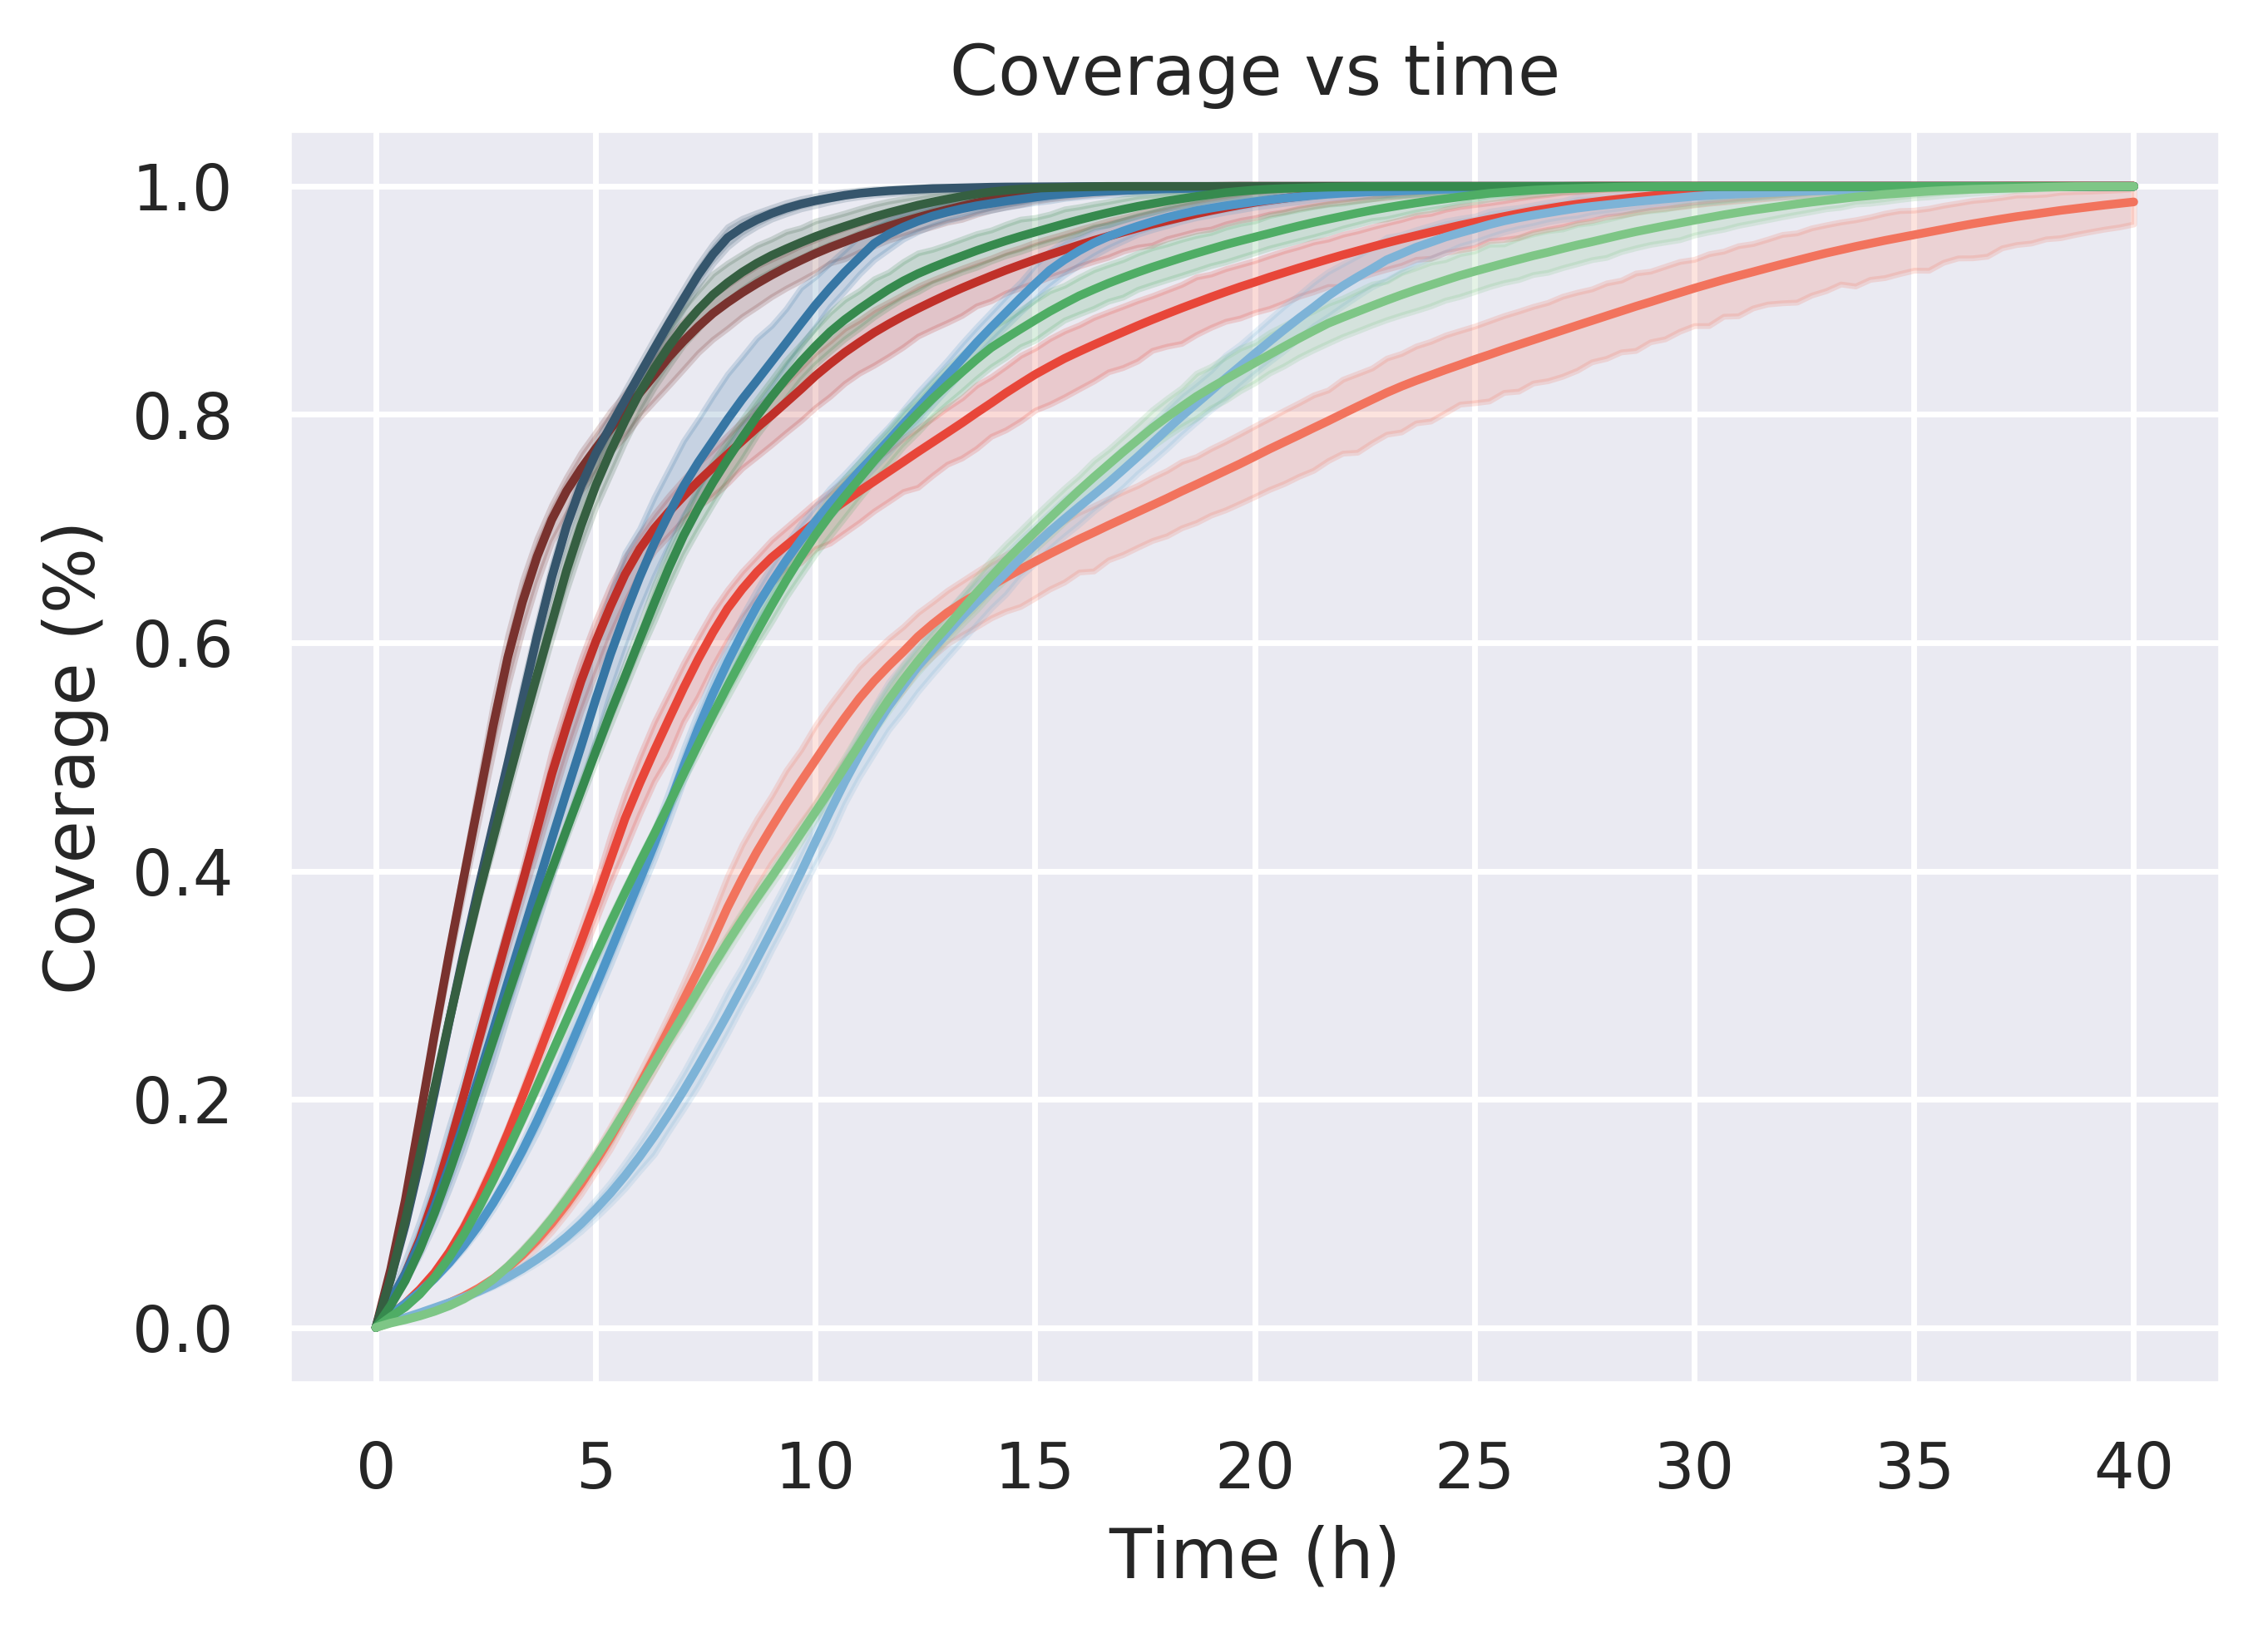

In [57]:
#plot total
fig = plt.figure(dpi=500)

#plot do threshold
#plt.hlines(0.75, dfplot['time_hours'].iloc[0], dfplot['time_hours'].iloc[-1], linestyle=':', color='black', linewidth=1.5)

#plot de cada dado
#sns.lineplot(data=dfplot, palette="Reds_d", dashes=False, legend='brief')
sns.lineplot(data=dfplot, palette="Reds_d", dashes=False, legend=False)

# for thrsh in range(1,5):    
sns.lineplot(data=dfplotdiag, palette="Blues_d", dashes=False, legend=False)
#plt.plot(df_final['Volume_' + str(thrsh)]/voltot, linestyle='-', linewidth=2.0, label = "Threshold = " + str(thrsh))

sns.lineplot(data=dfplotdiag2, palette="Greens_d", dashes=False, legend=False)


#label e eixos
plt.title('Coverage vs time')
plt.xlabel('Time (h)')
plt.ylabel('Coverage (%)')
#plt.legend([j + 'threshold = '+str(i)+' mol/L' for j in ['Centered model with ', 'Diagonal model with '] for i in range(1,5)],loc='lower right', shadow=False, fontsize='x-small')
plt.show()
#fig.savefig(fname = "teste1", dpi = 500)

In [199]:
def func(x, a, b):
    return (-1) * np.exp(- (x - b) / a) + 1

def func2(x, d, e):
    return d * np.power(x, 2) + e * x

def func3(x, a, b):
    return a * pow(x,2) + b

def func4(x, a, b, c, d, e, f, g):
    return a * np.exp(-b * x) + c * np.exp(-d * x) + e * np.exp(-f * x) + g

In [1]:
t = 8
time3 = data1['time'].loc[data1['time']>t*3600]/3600
vol3 = data3['Volume'].loc[data3['time']>t*3600]/voltot
popt3, pcov3 = curve_fit(func, time3, vol3)
time2 = data1['time'].loc[data1['time']<t*3600]/3600
vol2 = data3['Volume'].loc[data3['time']<t*3600]/voltot
popt2, pcov2 = curve_fit(func2, time2, vol2)
t = 41
time = data1['time'].loc[data1['time']<t*3600]/3600
vol = data1['Volume']/voltot
vol = vol.values
popt, pcov = curve_fit(func, time, data1['Volume'].loc[data1['time']<t*3600]/voltot)

NameError: name 'data1' is not defined

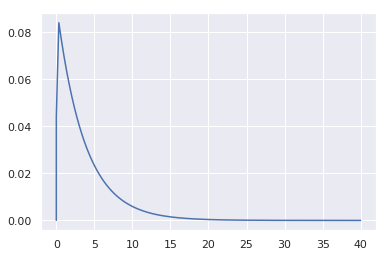

In [99]:
volexp = func(time, *popt)
plt.plot(time, np.gradient(volexp))
plt.show()

23    1.002778
28    2.669444
Name: time_hours, dtype: float64
24    1.336111
32    4.002778
36    5.336111
Name: time_hours, dtype: float64
26    2.002778
29    3.002778
34    4.669444
37    5.669444
44    8.002778
Name: time_hours, dtype: float64
30     3.336111
33     4.336111
39     6.336111
45     8.336111
51    10.336111
56    12.002778
Name: time_hours, dtype: float64


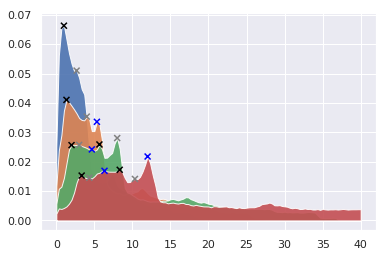

23    1.002778
26    2.002778
Name: time_hours, dtype: float64
31    3.669444
Name: time_hours, dtype: float64
36    5.336111
Name: time_hours, dtype: float64
42    7.336111
45    8.336111
Name: time_hours, dtype: float64


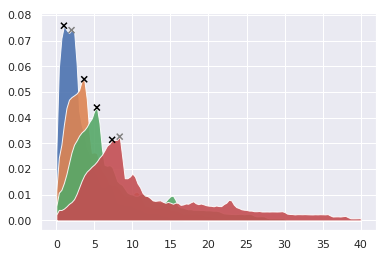

23    1.002778
Name: time_hours, dtype: float64
26    2.002778
34    4.669444
Name: time_hours, dtype: float64
31    3.669444
37    5.669444
41    7.002778
Name: time_hours, dtype: float64
38     6.002778
43     7.669444
50    10.002778
Name: time_hours, dtype: float64


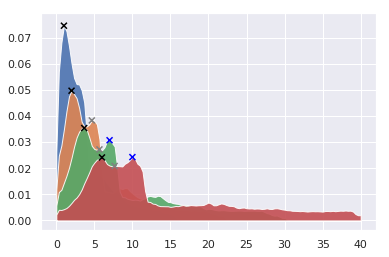

23    1.002778
28    2.669444
Name: time_hours, dtype: float64
26    2.002778
31    3.669444
Name: time_hours, dtype: float64
32    4.002778
36    5.336111
Name: time_hours, dtype: float64
43    7.669444
Name: time_hours, dtype: float64


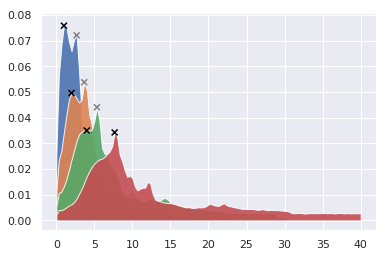

23    1.002778
27    2.336111
Name: time_hours, dtype: float64
27    2.336111
31    3.669444
34    4.669444
Name: time_hours, dtype: float64
33    4.336111
36    5.336111
41    7.002778
Name: time_hours, dtype: float64
39     6.336111
43     7.669444
52    10.669444
Name: time_hours, dtype: float64


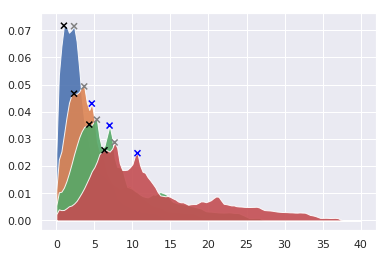

23    1.002778
28    2.669444
Name: time_hours, dtype: float64
26    2.002778
33    4.336111
Name: time_hours, dtype: float64
33    4.336111
38    6.002778
Name: time_hours, dtype: float64
44    8.002778
47    9.002778
Name: time_hours, dtype: float64


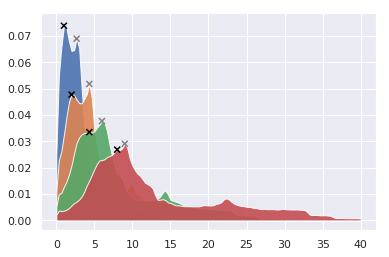

23    1.002778
28    2.669444
Name: time_hours, dtype: float64
28    2.669444
32    4.002778
Name: time_hours, dtype: float64
36    5.336111
Name: time_hours, dtype: float64
43     7.669444
47     9.002778
52    10.669444
Name: time_hours, dtype: float64


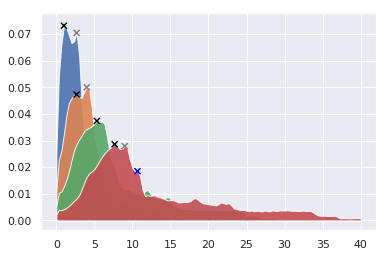

24    1.336111
27    2.336111
Name: time_hours, dtype: float64
31    3.669444
Name: time_hours, dtype: float64
35    5.002778
Name: time_hours, dtype: float64
43    7.669444
Name: time_hours, dtype: float64


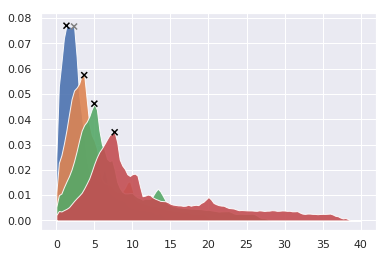

In [186]:
#maxTimeGrad = []

time = dfs_cent['df_3c_1']['time_hours']
for key in dfs_cent.keys():
    for thrsh in range(1,5):
        cov = dfs_cent[key]['Volume_'+str(thrsh)]/voltot    
        #maxTimeGrad += [time.iloc[np.argmax(np.gradient(vol))]]
        gradcov = np.gradient(cov)
        plt.fill_between(time, gradcov, alpha=0.9)
        indexes = peakutils.indexes(gradcov, thres=0.6, min_dist=2)
        print(time[indexes])
        plt.scatter(time[indexes], gradcov[indexes], c=['black','gray','blue'] , marker='x')
        #plt.plot(time, np.gradient(vol))
    plt.show()


In [79]:
#time.iloc[np.argmax(np.gradient(vol))]
#times = time.iloc[np.argpartition(np.gradient(vol),-2)[-2:]]
#np.gradient(vol)

In [84]:
#maxTimeGrad[3] = times.iloc[0]

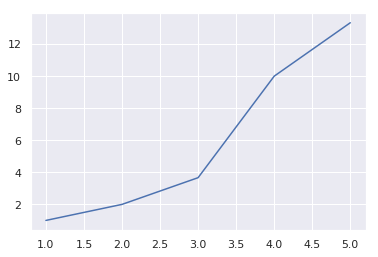

In [101]:
plt.plot([i+1 for i in range(0,5)], maxTimeGrad)
plt.show()

In [102]:
1/popt3[1]
1/popt[1]

42.55756111996147

[3.64667751 0.02349759] 
 [[ 5.71537784e-04 -5.65277913e-05]
 [-5.65277913e-05  5.94574865e-05]] 
 [0.02390686 0.00771087]
[8.16056039 0.57773098] 
 [[ 0.03357702 -0.04661422]
 [-0.04661422  0.07291224]] 
 [0.18324032 0.27002266]


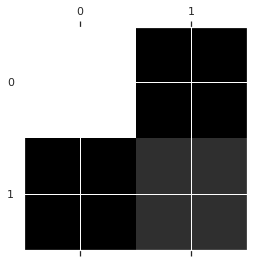

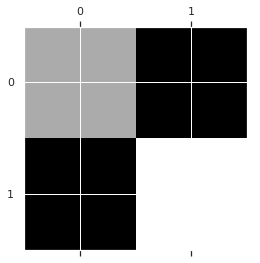

In [103]:
#plt.plot(time, func(time, *popt), 'm', linestyle ='--')
#plt.show()
#popt3
perr = np.sqrt(np.diag(pcov))
perr3 = np.sqrt(np.diag(pcov3))
print(popt, '\n', pcov, '\n', perr)
print(popt3, '\n', pcov3, '\n', perr3)
plt.matshow(pcov, cmap = plt.cm.gray)
plt.show()
plt.matshow(pcov3, cmap = plt.cm.gray)
plt.show()

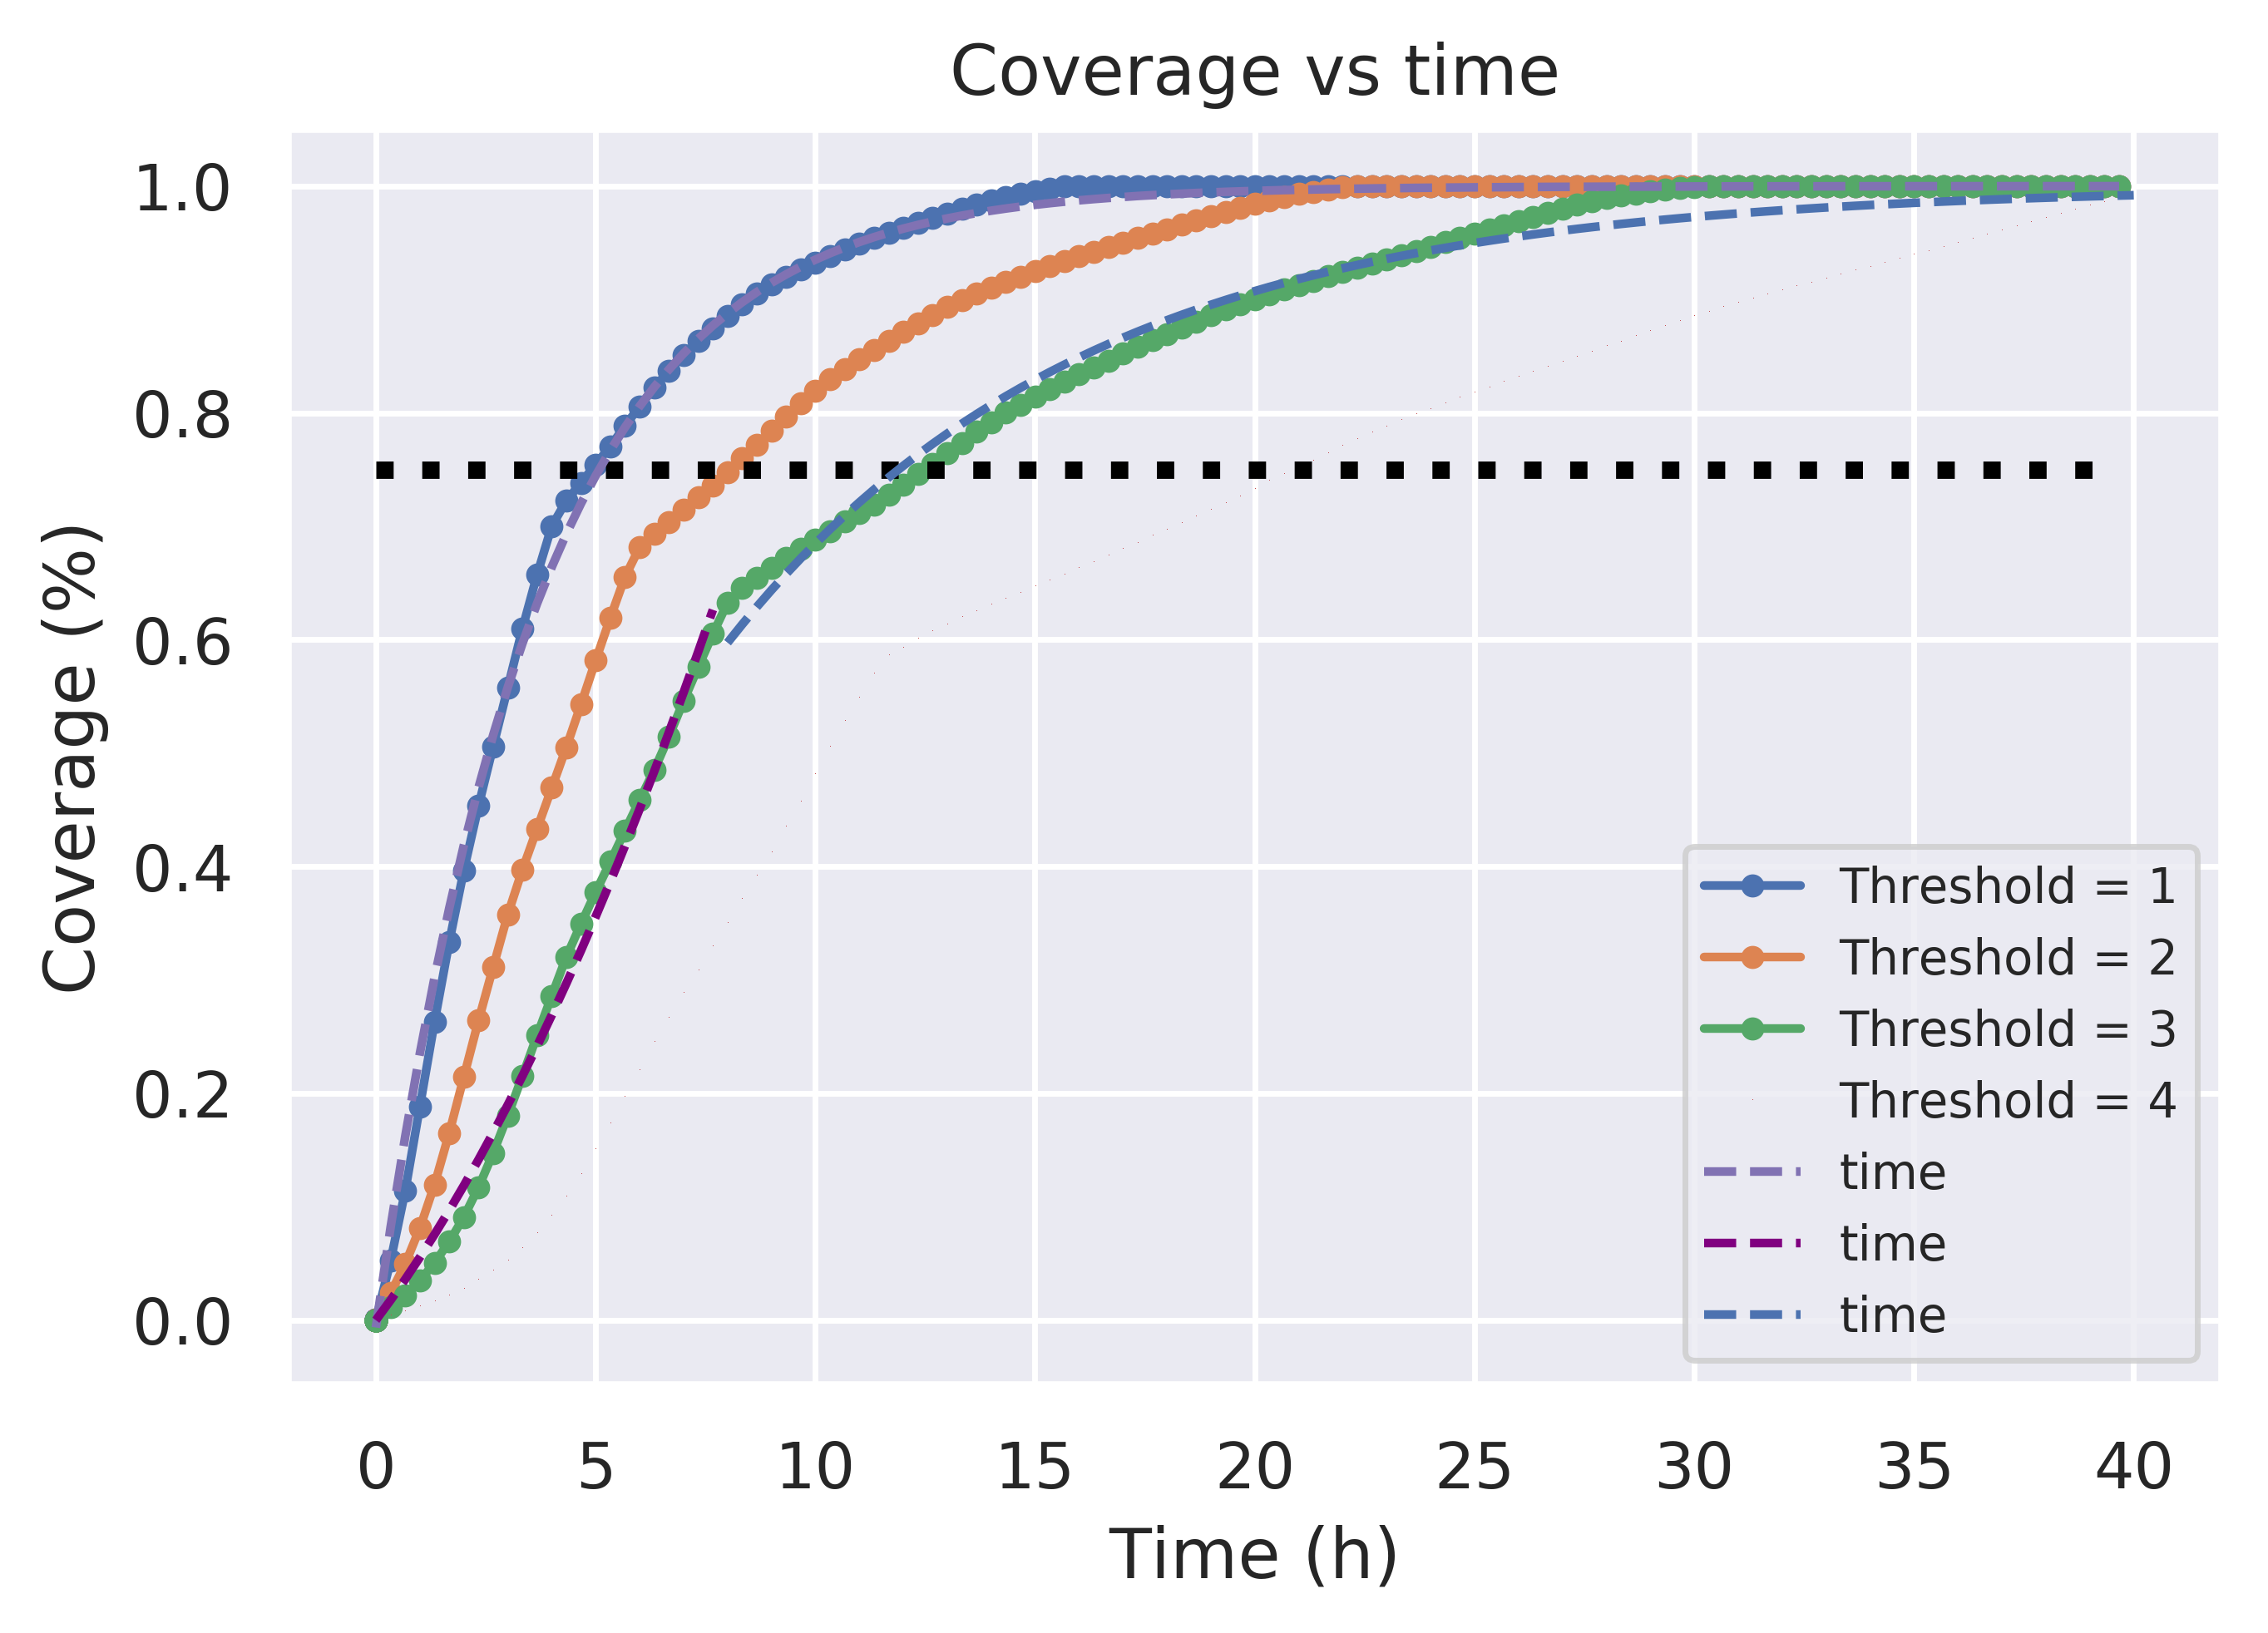

In [15]:
#Plot abaixo de um certo tempo t
sns.set()

t = int(40)
fig = plt.figure(dpi = 500)
ref2 = [0.75 for x in range(len(data1['time'].loc[data1['time']<t*3600]))]

#time = data1['time'].loc[data1['time']<t*3600]/3600

#plot de cada dado
plt.plot(time,data1['Volume'].loc[data1['time']<t*3600]*1000000/7.5, '.-', label = "Threshold = 1")
plt.plot(time,data2['Volume'].loc[data2['time']<t*3600]*1000000/7.5, '.-', label = "Threshold = 2")
plt.plot(time,data3['Volume'].loc[data3['time']<t*3600]*1000000/7.5, '.-', label = "Threshold = 3")
plt.plot(time,data4['Volume'].loc[data4['time']<t*3600]*1000000/7.5, ',', label = "Threshold = 4")
plt.plot(time, ref2, linestyle=':', color='black', linewidth=3)
#constant = 3.8
#expo = 1-np.exp(-(data1['time'].loc[data1['time']<t*3600]/3600)/constant)

plt.plot(time, func(time, *popt), 'm', linestyle ='--')

plt.plot(time2, func2(time2, *popt2), 'purple', linestyle ='--')
plt.plot(time3, func(time3, *popt3), 'b', linestyle ='--')
#plt.plot(time2, func2(time2, lin_reg.coef_[1], lin_reg.coef_[0]), 'purple', linestyle ='--')

#expo = 1-np.exp(-(data1['time'].loc[data1['time']<t*3600]/3600-3)/constant)
#time = data1['time'].loc[data1['time']<t*3600]/3600
#plt.plot(time, expo, 'r', linestyle ='--', (1,0))


#label e eixos
plt.title('Coverage vs time')
plt.xlabel('Time (h)')
plt.ylabel('Coverage (%)')
plt.legend(loc='lower right', shadow=False, fontsize='x-small')
plt.show()
#fig.savefig(fname = "demo", dpi = 500)

In [14]:
t = 8
X = data1['time'].loc[data1['time']<t*3600]/3600
X = X.values
X = np.array(X).reshape(-1,1)
y = data3['Volume'].loc[data3['time']<t*3600]*1000000/7.5
y = y.values

#from sklearn.linear_model import LinearRegression
#lin_reg = LinearRegression()
#lin_reg.fit(X,y)
#print(lin_reg.intercept_, lin_reg.coef_)

In [124]:
#from sklearn.preprocessing import PolynomialFeatures
#poly_features = PolynomialFeatures(degree = 2, include_bias = False)
#X_poly = poly_features.fit_transform(X)

#lin_reg.fit(X_poly, y)
#print(lin_reg.intercept_, lin_reg.coef_)

In [126]:
#popt2

In [125]:
#popt3